# Classification on Nursery Dataset
This notebook demonstrates model diagnostics on the nursery dataset https://www.openml.org/d/43938, originally https://doi.org/10.24432/C5P88W.

The response variable ***class*** has five different values: *not_recom*, *recommend*, *very_recom*, *priority*, *spec_prior*.

Our modelling goal is to estimate the conditional probability of $Y=1$, i.e. $P(Y=1|X)$, where $X$ are the features and $Y$ is defined as
$$
Y
= 
\begin{cases}
1 \text{ if class} \in \text{\{priority, special priority\}}\\
0 \text{ if otherwise }
\end{cases}
$$

Note is made that for binary classification $E(Y|X) = P(Y=1|X)$, that is, the conditional expected value equals the conditional probability of $Y$ being equal to one. Therefore, all the theory for the expectation functional applies to binary classification, probabilistic predictions are point predictions and scoring rules coincide with scoring functions.

The impatient reader can directly jump to chapters 3-4 where the capability of `model-diagnostics` are shown.
Chapters 1-2 are needed for data preparation and model training.

## 1. Data
### 1.1 Data Load and Preprocessing

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [2]:
X, y = fetch_openml(data_id=43938, as_frame=True, return_X_y=True, parser="auto")
df_original = pd.concat([X, y], axis=1)

In [3]:
df_original["class"].value_counts()

class
not_recom     4320
priority      4266
spec_prior    4044
very_recom     328
recommend        2
Name: count, dtype: int64

In [4]:
df = df_original.copy()
df["binary_response"] = df["class"].isin(["priority", "spec_prior"])
y_var = "binary_response"
x_vars = X.columns
print(f"The prepared dataset contains {df.shape[0]} rows.")

The prepared dataset contains 12960 rows.


In [5]:
df.head()

,parents,has_nurs,form,children,housing,finance,social,health,class,binary_response
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend,False
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority,True
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom,False
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend,False
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority,True


### 1.2 Contingency tables

4320 + 4320 = 8640 observations can be perfectly predicted using the feature *health*, as we can see in the contingency table below:

In [6]:
contingency_table = pd.crosstab(df["health"], df['binary_response'])    
print("Contingency Table:")
contingency_table

Contingency Table:


binary_response,False,True
health,,
not_recom,4320,0
priority,0,4320
recommended,330,3990


By further looking into the other features of the observations where $health=\text{recommended}$ we can see if one can completely predict the response variable using the other covariates as well.

We automate this procedure in section 2.3 by fitting a decision tree.

### 1.3 Data Split

In [7]:
df_train, df_test = train_test_split(df, train_size=0.75, random_state=1234321)
df = (
    pd.concat((df_train, df_test), axis=0, keys=("train", "test"))
    .reset_index(level=0)
    .rename(columns={"level_0": "split"})
)

y_train, y_test = df_train[y_var].astype(float), df_test[y_var].astype(float)
X_train, X_test = df_train[x_vars], df_test[x_vars]

We check whether the split results in two approximately identically distributed samples.

In [8]:
df.groupby("split")[["binary_response"]].mean()

,binary_response
split,
test,0.636420
train,0.642798


## 2. Models
Our modelling goal is to estimate the conditional probability of $Y=1$, i.e. $P(Y=1|X)$, and we will finally evaluate the models with the log loss $$S(y, z) = -y\log(z) - (1 - y) \log (1 - z)$$
### 2.1 The trivial model

In [9]:
from sklearn.dummy import DummyClassifier


m_trivial = DummyClassifier(strategy="prior").fit(X_train, y_train)

### 2.2 Logistic

Here, we train a Logistic Regression model.

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


# All variables are discrete.
x_discrete = x_vars
# ColumnTransformer for linear models
col_trans_cat = ColumnTransformer(
    [
        (
            "cat_features",
            OneHotEncoder(drop="first", sparse_output=False),
            x_discrete,
        ),
    ]
)
m_logistic = Pipeline(
    [
        ("column_transformer", col_trans_cat),
        (
            "model",
            LogisticRegression(
                penalty=None,
                solver="newton-cholesky",
            )
        ),
    ]
).fit(X_train, y_train)

We can have a look at the model coefficients.

In [11]:
feature_names = m_logistic[:-1].get_feature_names_out()
model_coefs = m_logistic.steps[-1][1].coef_.squeeze()
model_coefs = pd.DataFrame(
    {
        "coefficient": [x.removeprefix("cat_features__") for x in feature_names],
         "value": model_coefs,
    }
).sort_values(by="value")

with pd.option_context("display.max_rows", 20):
    display(model_coefs)

,coefficient,value
3,has_nurs_less_proper,-11.857906
4,has_nurs_proper,-11.849024
1,parents_usual,-11.532055
0,parents_pretentious,-10.116730
2,has_nurs_improper,-9.870463
5,has_nurs_very_crit,-0.097957
16,social_slightly_prob,0.000125
6,form_completed,0.829653
8,form_incomplete,1.767603
9,children_2,1.860888


### 2.3 Decision Tree
We will now train a `DecisionTreeClassifier` with default parameters, so no hyperparameter optimization.

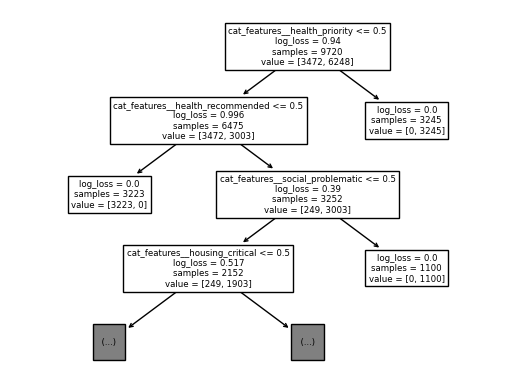

In [12]:
from sklearn.tree import DecisionTreeClassifier, plot_tree


# We can reuse the categorical one-hot encoding of the linear model.
m_tree = Pipeline(
    [
        ("column_transformer", col_trans_cat),
        (
            "model", DecisionTreeClassifier(
                criterion="log_loss", min_samples_leaf=2,
            )
        ),
    ]
).fit(X_train, y_train)

plot_tree(
    m_tree.steps[-1][1],
    feature_names=list(m_tree[:-1].get_feature_names_out()),
    max_depth=3,
);

The reading of the tree structure is difficult due to the one-hot encoding.
For instance, `cat_features__health_priority <= 0.5` means `health == priority` goes to the right, else to the left.
We can see that the first two splits have been performed as we previously did "by hand" on the feature *health*.

We restricted the tree plot to a depth of 3 for ease of readability. The tree has in fact a depth of 17.

In [13]:
m_tree.steps[-1][1].get_depth()

17

As the fitted decision tree has a large depth, we check how many observations are in each leaf.

In [14]:
# Get the leaf node assignments for each sample
leaf_ids = m_tree.steps[-1][1].apply(col_trans_cat.fit_transform(X_train))

# Count the samples in each leaf node
unique_leaf_ids = np.unique(leaf_ids)
leaf_samples = [np.sum(leaf_ids == node_id) for node_id in unique_leaf_ids]

np.sort(leaf_samples)[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Some leaf nodes contain only 2 observations, the minimum we set (which is quite low).

### 2.4 Gradient Boosted Decision Trees

We will now train a `HistGradientBoostingClassifier`.

In [15]:
%%time
# Note that this cell might take a few seconds.
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder


# ColumnTransformer for boosted trees
col_trans_bt = ColumnTransformer(
    [
        ("categorical_features", OrdinalEncoder(), x_discrete),
    ]
)

m_hgbt_base = Pipeline(
    [
        ("column_transformer", col_trans_bt),
        (
            "model", HistGradientBoostingClassifier(
                loss="log_loss",
                categorical_features=list(range(len(x_discrete))),
                max_iter=100,
                early_stopping=True,
                random_state=33,
                validation_fraction=0.2,
            )
        ),
    ]
)

param_grid = {
    "model__learning_rate": [0.6, 0.7, 0.8],  # quite large
    "model__l2_regularization": [0, 1e-6, 1e-3],
    "model__max_depth": [10, 15, 20],
    "model__min_samples_leaf": [2, 3, 4],
}


# successive halfing grid search (CV) on the training data
shgs = HalvingGridSearchCV(
    m_hgbt_base,
    param_grid=param_grid,
    cv=2,
    scoring="neg_log_loss",
    random_state=321,
).fit(X_train, y_train)

m_hgbt = shgs.best_estimator_

CPU times: user 25 s, sys: 313 ms, total: 25.3 s
Wall time: 6.41 s


In [16]:
shgs.best_params_, shgs.best_score_

({'model__l2_regularization': 1e-06,
  'model__learning_rate': 0.7,
  'model__max_depth': 15,
  'model__min_samples_leaf': 2},
 -6.40295807008405e-05)

In [17]:
m_hgbt[-1].n_iter_

27

## 3. Calibration Assessment
To make the code easier, we put together the predictions of all of our models on the test set in a single dataframe.

In [18]:
models = [m_trivial, m_logistic, m_tree, m_hgbt]
model_names = ["Trivial", "Logistic", "Tree", "HGBT"]

df_pred_test = pd.DataFrame(
    {name: m.predict_proba(X_test)[:, 1] for m, name in zip(models, model_names)}
)

## 3.1. Reliability Diagrams
A reliability diagram plots an estimation of $E(Y|m(X))$ versus $m(X)$ and therefore assesses auto-calibration.
Good auto-calibration is seen by closeness to the diagonal depicted as dotted line.

A good way to estimate $E(Y|m(X))$ and thereby avoiding manual binning is by isotonic regression.
This is implemented in `plot_reliability_diagram`.

In [19]:
import matplotlib.pyplot as plt
from model_diagnostics.calibration import compute_bias, plot_bias, plot_reliability_diagram

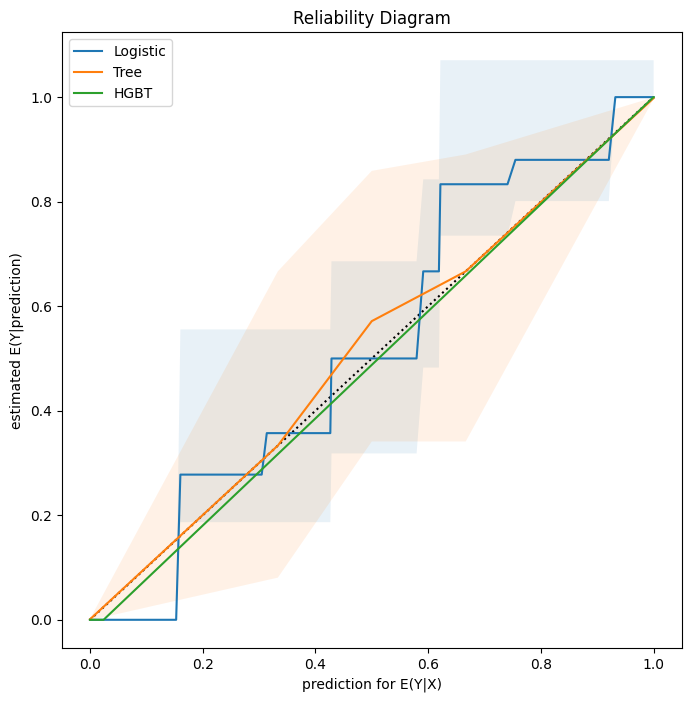

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_reliability_diagram(
    y_obs=y_test,
    y_pred=df_pred_test[["Logistic", "Tree", "HGBT"]],
    n_bootstrap=100,
    ax=ax,
);

The HGBT model is very close to be auto-calibrated.
A comment regarding the strong performance of the HGBT model is in section 4.1.

### 3.2 Conditional Bias
#### Unconditional Bias

In [21]:
compute_bias(
    y_obs=y_test,
    y_pred=df_pred_test,
    feature=None,
)

model,bias_mean,bias_count,bias_weights,bias_stderr,p_value
str,f64,u32,f64,f64,f64
"""Trivial""",0.006379,3240,3240.0,0.008452,0.4505
"""Logistic""",-0.001374,3240,3240.0,0.001493,0.357317
"""Tree""",0.000772,3240,3240.0,0.000878,0.379312
"""HGBT""",0.000008,3240,3240.0,0.000007,0.298421


#### Bias Conditional on parents

In [22]:
compute_bias(
    y_obs=y_test,
    y_pred=df_pred_test,
    feature=X_test["parents"],
)

model,parents,bias_mean,bias_count,bias_weights,bias_stderr,p_value
str,cat,f64,u32,f64,f64,f64
"""Trivial""","""great_pret""",-0.009376,1104,1104.0,0.014341,0.513399
"""Trivial""","""pretentious""",-0.00183,1089,1089.0,0.01451,0.899677
"""Trivial""","""usual""",0.031528,1047,1047.0,0.015072,0.036696
"""Logistic""","""great_pret""",-0.000006,1104,1104.0,0.000017,0.726384
"""Logistic""","""pretentious""",0.000139,1089,1089.0,0.003114,0.964296
"""Logistic""","""usual""",-0.004392,1047,1047.0,0.003295,0.1828
"""Tree""","""great_pret""",0.0,1104,1104.0,0.0,0.0
"""Tree""","""pretentious""",0.002296,1089,1089.0,0.002415,0.342047
"""Tree""","""usual""",-1.0604e-19,1047,1047.0,0.001032,1.0


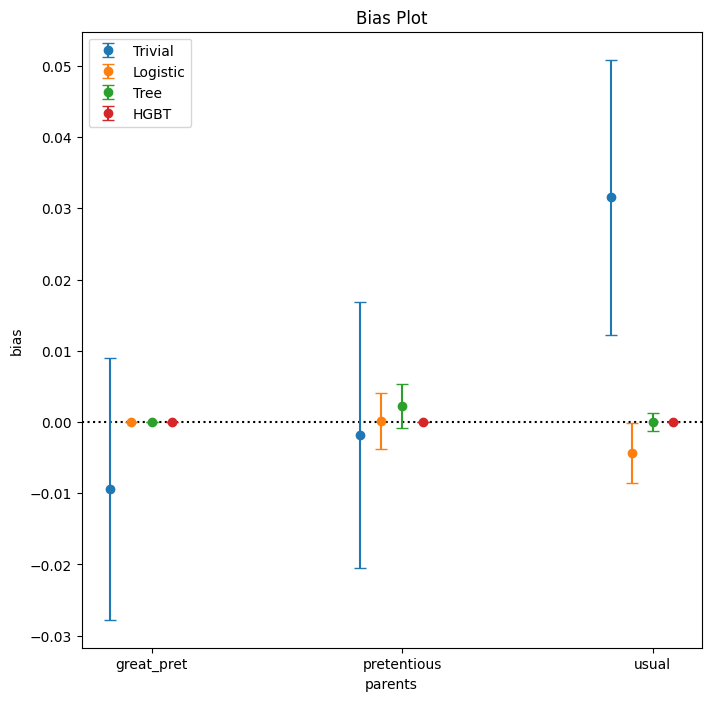

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_bias(
    y_obs=y_test,
    y_pred=df_pred_test,
    feature=X_test["parents"],
    confidence_level=0.8
);

## 4. Predictive Model Performance
### 4.1 Score Decomposition of the Log Loss
We use the [log loss](https://lorentzenchr.github.io/model-diagnostics/reference/model_diagnostics/scoring/scoring/#model_diagnostics.scoring.scoring.LogLoss) and evaluate on the test set.
On top, we additively decompose the scores in terms of miscalibration (smaller is better), discrimination (larger is better) and uncertainty (property of the data, same for all models).

In [24]:
from model_diagnostics.scoring import LogLoss, decompose


log_loss = LogLoss()

df = decompose(
    y_obs=y_test,
    y_pred=df_pred_test,
    scoring_function=log_loss,
)
df.sort(["score"])

model,miscalibration,discrimination,uncertainty,score
str,f64,f64,f64,f64
"""HGBT""",0.000009,0.65545,0.65545,0.000009
"""Logistic""",0.003509,0.635995,0.65545,0.022964
"""Trivial""",0.000088,0.0,0.65545,0.655539
"""Tree""",inf,0.641366,0.65545,inf


First, the HGBT model has the best (smallest) log loss in column **score**.
We also see that the uncertainty term is model independent as it is a property of the data and the scoring function only.

The HGBT model is superior compared to the logistic and to the tree model both in terms of the **miscalibration** (lower) and of the **discrimination** (higher).
HGBT has a score close to zero, so it seems to almost perfectly predict the target variable.

The tree model, however, has an infinite score and infinite miscalibration due to few predictions being equal to 1 when $Y=0$ (4 observations, see below) or vice versa (2 observations, see below).
This can be seen as a weekness of the log loss: it penalizes false certainty (predicting probabilities of 0 or 1, contradicting to the data) with infinity.

The good performance of the tree-based models might suggest that the data was "generated" following a decision-tree-like approach, whose logic the models can then learn given that all the required covariates are available.

In [25]:
np.sum((df_pred_test["Tree"] == 1) & (y_test.values == 0))

4

In [26]:
np.sum((df_pred_test["Tree"] == 0) & (y_test.values == 1))

1

### 4.2 Murphy Diagram
How does the ranking of the model performances change with other scoring functions?
Is one model dominating the others for a wide range of scoring functions?
Such questions can be handily answered by a Murphy diagram.
It plots the mean score for a wide range of elementary scoring functions, parametrized by `eta` on the x-axis.
We just specify the number of `etas`, the plot finds out meaningfull min and max values.

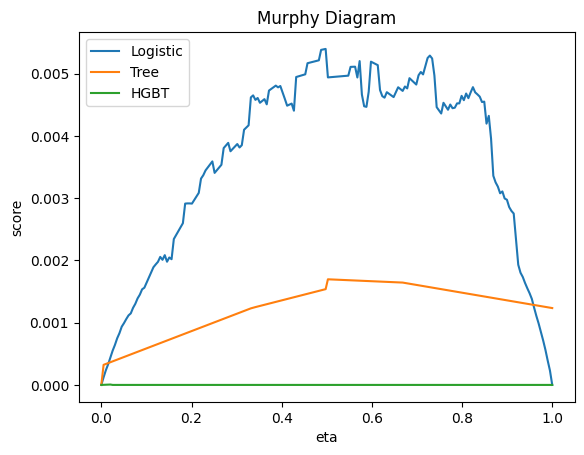

In [27]:
from model_diagnostics.scoring import SquaredError, plot_murphy_diagram


plot_murphy_diagram(
    y_obs=y_test,
    y_pred=df_pred_test.loc[:, ["Logistic", "Tree", "HGBT"]],
    etas=200,
);

The HGBT model seems to have almost perfect score (0 is the minimal attainable value) over the whole range of etas and therefore dominates all other models.

We show this on the score decomposition of the squared error, which is called Brier score in the context of classification.

In [28]:
decompose(
    y_obs=y_test,
    y_pred=df_pred_test,
    scoring_function=SquaredError(),
).sort(["score"])

model,miscalibration,discrimination,uncertainty,score
str,f64,f64,f64,f64
"""HGBT""",1.7994e-7,0.23139,0.23139,1.7994e-7
"""Tree""",0.000014,0.228908,0.23139,0.002495
"""Logistic""",0.000862,0.22503,0.23139,0.007221
"""Trivial""",0.000041,0.0,0.23139,0.23143
